In [1]:
import pandas as pd
import geopandas as gpd


/home/ryzzr/miniconda3/envs/PDP/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
df_f = pd.read_csv('data/dane_szczepien.csv', sep=';',
                   encoding='utf-8')[['powiat_nazwa', 'wojewodztwo_nazwa']].groupby(['powiat_nazwa', 'wojewodztwo_nazwa']).sum().reset_index()


In [3]:
# df = pd.read_csv('daneaktualne_szczepienia/20220123075316_rap_rcb_pow_szczepienia.csv',
#                  sep=';', encoding='windows-1250')
df_vacc = pd.read_csv('data/dane_szczepien.csv', sep=';',
                      encoding='utf-8').groupby('powiat_nazwa').sum().reset_index()
df_vacc = pd.merge(df_vacc, df_f, on='powiat_nazwa')
df_vacc_filtered = df_vacc[['powiat_nazwa', 'wojewodztwo_nazwa', 'powiat_teryt', 'liczba_ludnosci',
                            'w1_zaszczepieni_pacjenci', 'w3_zaszczepieni_pelna_dawka']]
df_distr = gpd.read_file("data/powiaty-max.geojson")

In [4]:
df_distr['powiat_nazwa'] = df_distr['nazwa'].apply(lambda x: x.split(' ')[-1])
df_vacc_filtered['czesc_wyszczepienia'] = df_vacc_filtered['w3_zaszczepieni_pelna_dawka'] / df_vacc_filtered['liczba_ludnosci']


/tmp/ipykernel_9007/846998864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vacc_filtered['czesc_wyszczepienia'] = df_vacc_filtered['w3_zaszczepieni_pelna_dawka'] / df_vacc_filtered['liczba_ludnosci']


In [5]:
print(df_distr.shape)
print(df_vacc_filtered.shape)


(380, 4)
(380, 7)


In [6]:
full_df = pd.merge(df_distr, df_vacc_filtered, on='powiat_nazwa')


# Folium

In [ ]:
import folium

In [ ]:
geo_powiaty = "stance_detection_geotwitter/data/powiaty-max.geojson"
with open(geo_powiaty, encoding="utf8") as file_powiaty:
    text_powiaty = file_powiaty.read()


In [ ]:
m = folium.Map(location=[52, 19.23], zoom_start=7, tiles='stamentoner')
folium.Choropleth(geo_data=text_powiaty,
    data=full_df,
    columns=['nazwa', 'czesc_wyszczepienia'],
    legend_name='Część wyszczepienia',
    fill_color='PuBu',
    fill_opacity=0.7,
    line_opacity=0.5,
    key_on='feature.properties.nazwa',
).add_to(m)

m


# Dane z AMC


In [7]:
df_amc = pd.read_json(
    "data/location_data_all_v2.json")[['powiat_str', 'latitude', 'longitude', 'y3classes_sum', 'y3classes_str_general']]
df_amc['nazwa'] = df_amc['powiat_str']
df_amc.drop('powiat_str', axis=1)

df_amc = df_amc.groupby('nazwa').sum().reset_index()


In [158]:
full_df_amc = pd.merge(df_amc, full_df, on='nazwa')

In [159]:
full_df_amc = gpd.GeoDataFrame(full_df_amc)


# ML

In [175]:
variable_names = [
    'y3classes_sum',
    'powiat_teryt',
    'liczba_ludnosci',
]


In [161]:
from pysal.model import spreg


In [162]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    full_df_amc[variable_names].values,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variable name
    name_x=variable_names
)


In [163]:
print(m1.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :           4
S.D. dependent var  :      0.0658                Degrees of Freedom    :         360
R-squared           :      0.1497
Adjusted R-squared  :      0.1426
Sum squared residual:       1.338                F-statistic           :     21.1251
Sigma-square        :       0.004                Prob(F-statistic)     :   1.256e-12
S.E. of regression  :       0.061                Log likelihood        :     503.794
Sigma-square ML     :       0.004                Akaike info criterion :    -999.588
S.E of regression ML:      0.0606                Schwarz criterion     :    -983.999

----------------------------------------------------------------------

In [164]:
from pysal.lib import weights
knn = weights.KNN.from_dataframe(full_df_amc, k=1)


Text(0, 0.5, 'Spatial Lag of Model Residuals - $W u$')

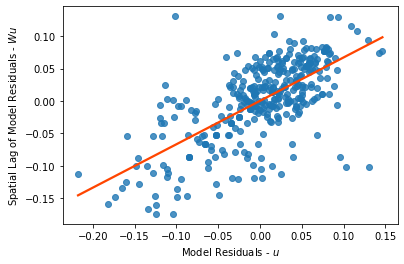

In [165]:
import seaborn

lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$')


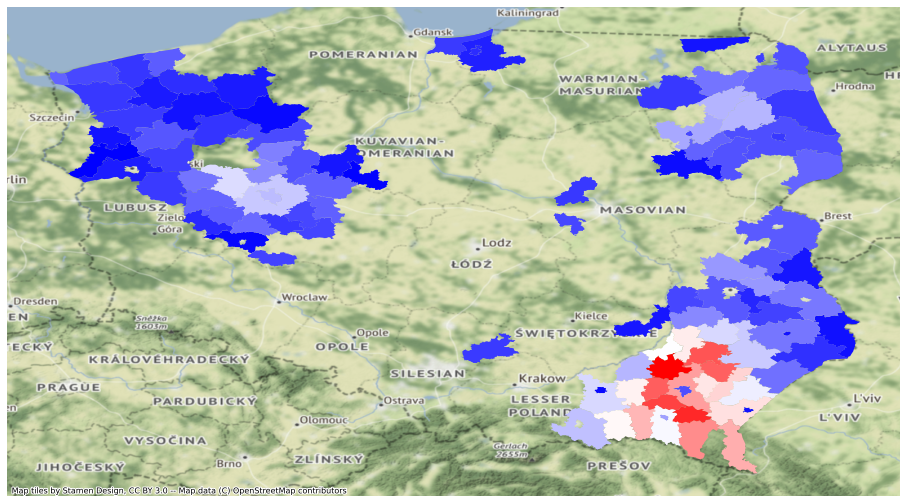

In [166]:
from pysal.explore import esda
import contextily
import matplotlib.pyplot as plt


# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardise weights
knn.transform = 'R'
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .001)
# Add `error_clusters` and `local_I` columns
ax = full_df_amc.assign(
    error_clusters=error_clusters,
    local_I=outliers.Is
    # Retain error clusters only
).query(
    "error_clusters"
    # Sort by I value to largest plot on top
).sort_values(
    'local_I'
    # Plot I values
).plot(
    'local_I', cmap='bwr', marker='.', figsize=(16, 16)
)
# Add basemap
contextily.add_basemap(ax, crs=full_df_amc.crs)
# Remove axes
ax.set_axis_off()


THERE IS ROOM FOR SPATIAL IMPROVEMENT!!!!

# Spatial ML

In [167]:
import statsmodels.formula.api as sm
from shapely.geometry import Point


In [168]:
# Czy jest w pobliżu najlepiej komentujących?
rk = weights.Rook.from_dataframe(full_df_amc)

full_df_amc['pos_neg_per_person'] = full_df_amc['y3classes_sum'] / full_df_amc['liczba_ludnosci']
full_df_amc['neighbouring_powiaty'] = [[full_df_amc.iloc[x]['powiat_nazwa'] for x in n_powiaty]
                                       for n_powiaty in list(rk.neighbors.values())]

most_pos = list(full_df_amc.sort_values('pos_neg_per_person', ascending=False).head(25)['powiat_nazwa'])
most_neg = list(full_df_amc.sort_values('pos_neg_per_person', ascending=True).head(25)['powiat_nazwa'])

def powiatowy(x):
    total = 0
    for y in x:
        if y in most_pos:
            total += 1
        elif y in most_neg:
            total -= 1
    return 1 if total > 0 else -1 if total < 0 else 0 

full_df_amc['neighborhood_pozytywny'] = full_df_amc['neighbouring_powiaty'].apply(powiatowy)


<AxesSubplot:>

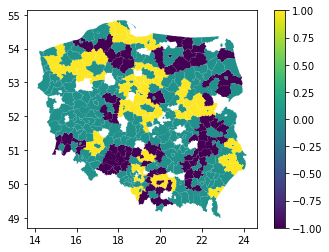

In [145]:
full_df_amc.plot(column='neighborhood_pozytywny', categorical=False, legend=True)


In [176]:
# variable_names.append('neighborhood_pozytywny')
variable_names.append('pos_neg_per_person')

### Po dodaniu województw jako zależności geograficznych.

In [147]:
# PySAL spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    full_df_amc[variable_names].values,
    # Variable specifying neighborhood membership
    full_df_amc['wojewodztwo_nazwa'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False]*len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=variable_names
)


In [148]:
print(m4.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :          20
S.D. dependent var  :      0.0658                Degrees of Freedom    :         344
R-squared           :      0.6186
Adjusted R-squared  :      0.5975
Sum squared residual:       0.600                F-statistic           :     29.3598
Sigma-square        :       0.002                Prob(F-statistic)     :    1.87e-60
S.E. of regression  :       0.042                Log likelihood        :     649.692
Sigma-square ML     :       0.002                Akaike info criterion :   -1259.383
S.E of regression ML:      0.0406                Schwarz criterion     :   -1181.440

--------------------------------------------------

Text(0, 0.5, 'Spatial Lag of Model Residuals - $W u$')

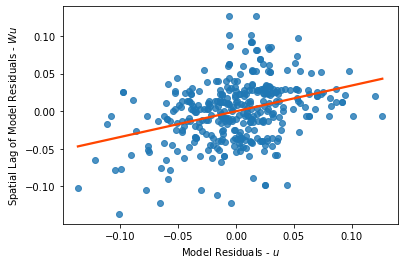

In [149]:
knn = weights.KNN.from_dataframe(full_df_amc, k=1)
lag_residual = weights.spatial_lag.lag_spatial(knn, m4.u)
ax = seaborn.regplot(
    m4.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$')


### Po sprawdzeniu "najbardziej pozytywnych i negatywnych" sąsiadów jako zależności geo

In [150]:
# PySAL spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    full_df_amc[variable_names].values,
    # Variable specifying neighborhood membership
    full_df_amc['neighborhood_pozytywny'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=variable_names
)


In [151]:
print(m5.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :          15
S.D. dependent var  :      0.0658                Degrees of Freedom    :         349
R-squared           :      0.2432
Adjusted R-squared  :      0.2128
Sum squared residual:       1.191                F-statistic           :      8.0107
Sigma-square        :       0.003                Prob(F-statistic)     :   7.784e-15
S.E. of regression  :       0.058                Log likelihood        :     524.996
Sigma-square ML     :       0.003                Akaike info criterion :   -1019.993
S.E of regression ML:      0.0572                Schwarz criterion     :    -961.535

--------------------------------------------------

### The SLX Model - dodanie spacial lag'a

In [179]:
wx = full_df_amc[variable_names].apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
    # Rename the spatial lag, adding w_ to the original name
).rename(columns=lambda c: 'w_'+c
    # Remove the lag of the binary variable for apartments
         )

slx_exog = full_df_amc[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=slx_exog.columns.tolist()
)


In [180]:
print(m6.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :           9
S.D. dependent var  :      0.0658                Degrees of Freedom    :         355
R-squared           :      0.2052
Adjusted R-squared  :      0.1873
Sum squared residual:       1.251                F-statistic           :     11.4542
Sigma-square        :       0.004                Prob(F-statistic)     :    1.77e-14
S.E. of regression  :       0.059                Log likelihood        :     516.073
Sigma-square ML     :       0.003                Akaike info criterion :   -1014.145
S.E of regression ML:      0.0586                Schwarz criterion     :    -979.071

----------------------------------------------------------------------

# All together!

In [181]:
full_df_amc = pd.merge(df_amc, full_df, on='nazwa')
full_df_amc = gpd.GeoDataFrame(full_df_amc)

variable_names = [
    'y3classes_sum',
    'powiat_teryt',
    'liczba_ludnosci',
]

rk = weights.Rook.from_dataframe(full_df_amc)

full_df_amc['pos_neg_per_person'] = full_df_amc['y3classes_sum'] / full_df_amc['liczba_ludnosci']
full_df_amc['neighbouring_powiaty'] = [[full_df_amc.iloc[x]['powiat_nazwa'] for x in n_powiaty]
                                       for n_powiaty in list(rk.neighbors.values())]

most_pos = list(full_df_amc.sort_values('pos_neg_per_person', ascending=False).head(25)['powiat_nazwa'])
most_neg = list(full_df_amc.sort_values('pos_neg_per_person', ascending=True).head(25)['powiat_nazwa'])


def powiatowy(x):
    total = 0
    for y in x:
        if y in most_pos:
            total += 1
        elif y in most_neg:
            total -= 1
    return 1 if total > 0 else -1 if total < 0 else 0


full_df_amc['neighborhood_pozytywny'] = full_df_amc['neighbouring_powiaty'].apply(powiatowy)

variable_names.append('neighborhood_pozytywny') # Adding this info as a var
variable_names.append('pos_neg_per_person')

knn = weights.KNN.from_dataframe(full_df_amc, k=20)
wx = full_df_amc[variable_names].apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
    # Rename the spatial lag, adding w_ to the original name
).rename(columns=lambda c: 'w_'+c
         # Remove the lag of the binary variable for apartments
         )

slx_exog = full_df_amc[variable_names].join(wx)


In [155]:
slx_exog.iloc[0]


y3classes_sum               4.000000e+02
powiat_teryt                2.061000e+03
liczba_ludnosci             2.969580e+05
neighborhood_pozytywny      0.000000e+00
pos_neg_per_person          1.346992e-03
w_y3classes_sum             4.680000e+02
w_powiat_teryt              3.805580e+05
w_liczba_ludnosci           1.904465e+06
w_neighborhood_pozytywny   -6.000000e+00
w_pos_neg_per_person        6.313307e-03
Name: 0, dtype: float64

In [182]:
m7 = spreg.OLS_Regimes(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    slx_exog.values,
    # Variable specifying neighborhood membership
    full_df_amc['wojewodztwo_nazwa'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False]*len(variable_names)*2,
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=slx_exog.columns.tolist()
)


In [183]:
print(m7.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :          26
S.D. dependent var  :      0.0658                Degrees of Freedom    :         338
R-squared           :      0.6494
Adjusted R-squared  :      0.6235
Sum squared residual:       0.552                F-statistic           :     25.0467
Sigma-square        :       0.002                Prob(F-statistic)     :   3.893e-62
S.E. of regression  :       0.040                Log likelihood        :     665.058
Sigma-square ML     :       0.002                Akaike info criterion :   -1278.116
S.E of regression ML:      0.0389                Schwarz criterion     :   -1176.790

--------------------------------------------------

# TEST AREA